# Contribution
Gurmat, N01715331 <br>
Robert, <br>
Minh <br>

This project analyzes a large dataset from hospitals containing ten years of information about patients with diabetes. Our main goal is to use this data to predict a simple but very important question: "Is this patient likely to be readmitted to the hospital within 30 days of being discharged?
<br>Why is this Important?<br>

<br>Answering this question is crucial for a few key reasons:

    Better Patient Care: If we can identify patients at high risk of being readmitted, hospitals can provide them with extra care, follow-up appointments, or resources to help them stay healthy at home.

    Reduced Healthcare Costs: Hospital readmissions are very expensive. By preventing them, we can help make the healthcare system more efficient.

```[ START: Raw Diabetic Patient Data (.csv) ]
                   |
                   |
                   v
+-----------------------------------------------+
|  1. Load & Explore Data                       |
|     - Load CSV into DataFrame.                |
|     - Inspect shape, columns, and data types. |
|     - Understand initial distributions.       |
+-----------------------------------------------+
                   |
                   |
                   v
+-----------------------------------------------+
|  2. Clean & Filter Data                       |
|     - Remove columns with high % of missing.  |
|     - Handle '?' or invalid entries.          |
|     - Filter out non-predictive rows          |
|       (e.g., expired patients).               |
+-----------------------------------------------+
                   |
                   |
                   v
+-----------------------------------------------+
|  3. Engineer "Smarter" Features               |
|     - Create patient-level histories          |
|       (e.g., total visits, total days).       |
|     - Standardize and group diagnosis codes.  |
|     - Create flags for high-risk combos.      |
|     - Consolidate medication information.     |
+-----------------------------------------------+
                   |
                   |
                   v
+-----------------------------------------------+
|  4. Finalize Dataset                          |
|     - Drop all intermediate/temp columns.     |
|     - Ensure final data types are correct.    |
|     - Save the clean DataFrame.               |
+-----------------------------------------------+
                   |
                   |
                   v
[ END: Clean, Model-Ready Dataset ]
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_info_columns', 200)

In [2]:

# https://archive.ics.uci.edu/dataset/296/medical_data+130-us+hospitals+for+years+1999-2008
medical_data=pd.read_csv('data/diabetic_data.csv')

print(medical_data.shape)
print(medical_data.columns)

(101766, 50)
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [3]:
#dropping features considered in exploratory work (separate ipynb files)
drop=['race', 'weight', 'medical_specialty', 'max_glu_serum']

In [4]:
# admission_type_id is a categorical feature, so we will convert it to a dictionary for better readability
admission_type_id = { 1 : 'Emergency'  # Emergency admission
, 2 : 'Urgent' # Urgent admission
, 3 : 'Elective' # Elective admission
, 4 : 'Newborn' # Newborn admission
, 5 : 'Not Available' # Not available admission type
, 6 : 'NULL' # NULL admission type
, 7 : 'Trauma Center' # Trauma center admission
, 8 : 'Not Mapped' } #  Not mapped admission type

In [5]:
# discharge_disposition_id is a categorical feature, so we will convert it to a dictionary for better readability
discharge_disposition_id = { 1 : 'Discharged to home' 
, 2 : 'Discharged/transferred to another short term hospital'
, 3 : 'Discharged/transferred to SNF'
, 4 : 'Discharged/transferred to ICF'
, 5 : 'Discharged/transferred to another type of inpatient care institution'
, 6 : 'Discharged/transferred to home with home health service'
, 7 : 'Left AMA'
, 8 : 'Discharged/transferred to home under care of Home IV provider'
, 9 : 'Admitted as an inpatient to this hospital'
, 10 : 'Neonate discharged to another hospital for neonatal aftercare'
, 11 : 'Expired'
, 12 : 'Still patient or expected to return for outpatient services'
, 13 : 'Hospice / home' 
, 14 : 'Hospice / medical facility'
, 15 : 'Discharged/transferred within this institution to Medicare approved swing bed'
, 16 : 'Discharged/transferred/referred another institution for outpatient services'
, 17 : 'Discharged/transferred/referred to this institution for outpatient services'
, 18 : 'NULL'
, 19 : 'Expired at home. Medicaid only, hospice'
, 20 : 'Expired in a medical facility. Medicaid only, hospice'
, 21 : 'Expired, place unknown. Medicaid only, hospice'
, 22 : 'Discharged/transferred to another rehab fac including rehab units of a hospital'
, 23 : 'Discharged/transferred to a long term care hospital'
, 24 : 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare'
, 25 : 'Not Mapped'
, 26 : 'Unknown/Invalid'
, 30 : 'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
, 27 : 'Discharged/transferred to a federal health care facility'
, 28 : 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital'
, 29 : 'Discharged/transferred to a Critical Access Hospital (CAH)' }

In [6]:
admission_source_id = { 1 : 'Physician Referral'
, 2 : 'Clinic Referral'
, 3 : 'HMO Referral'
, 4 : 'Transfer from a hospital'
, 5 : 'Transfer from a Skilled Nursing Facility (SNF)'
, 6 : 'Transfer from another health care facility'
, 7 : 'Emergency Room'
, 8 : 'Court/Law Enforcement'
, 9 :  'Not Available'
, 10 : 'Transfer from critial access hospital'
, 11 : 'Normal Delivery'
, 12 : 'Premature Delivery'
, 13 : 'Sick Baby'
, 14 : 'Extramural Birth'
, 15 : 'Not Available'
, 17 : 'NULL'
, 18 : 'Transfer From Another Home Health Agency'
, 19 : 'Readmission to Same Home Health Agency'
, 20 : 'Not Mapped'
, 21 : 'Unknown/Invalid'
, 22 : 'Transfer from hospital inpt/same fac reslt in a sep claim'
, 23 : 'Born inside this hospital'
, 24 : 'Born outside this hospital'
, 25 : 'Transfer from Ambulatory Surgery Center'
, 26 : 'Transfer from Hospice'
                      }

<br>11 : 'Expired'<br>
<br>13 : 'Hospice / home'<br>
<br>14 : 'Hospice / medical facility'<br>
<br>19 : 'Expired at home. Medicaid only, hospice'<br>
<br>20 : 'Expired in a medical facility. Medicaid only, hospice'<br>
<br>21 : 'Expired, place unknown. Medicaid only, hospice'<br>

these are dead patient, we don't need our model to learn about them

In [7]:
medical_data['expiration_ind'] = medical_data['discharge_disposition_id'].isin([11,13,14,19,20,21]).astype('int')

The cell above o handles the categorical ID columns: admission_type_id, discharge_disposition_id, and admission_source_id. The raw data uses numerical codes (e.g., 1 for 'Emergency'), which are not inherently meaningful for a model. Our process transforms these IDs into valuable predictive features.
Why This Step is Important

    Making Data Readable: We start by mapping the numeric IDs to their text descriptions (e.g., changing 1 to 'Emergency'). This makes the data much easier for us to read, understand, and debug.

    Reducing Complexity by Grouping: Many of the categories are very specific and don't have many patient records. Using them individually can make the model too complex and less effective. To solve this, we group related categories into broader, more meaningful buckets. For example, we create a single group for all 'Emergency' and 'NULL' admission types. These broader groups often have more predictive power.

    Creating Historical Patient Summaries: This is the most crucial part. For each of the new groups we created, we calculate a historical count for every patient. For instance, we create a feature called mb_admission_grp_1_ct which stores the total number of times a patient has had an 'Emergency' or 'NULL' admission across all their hospital visits. This summary of a patient's history is a very strong predictor of future behavior.

    Cleaning Up: Finally, once we have extracted all this valuable information and created our new historical features, we no longer need the original ID columns or the temporary grouping columns. We schedule them for removal to keep our final dataset clean and efficient.

The Code with Detailed Comments

Below is your code block with detailed comments explaining each line. I have also included code to generate a plot that helps visualize the distribution of the new feature groups you created.

/tmp/ipykernel_8892/2805948647.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Feature Group', data=plot_df.sort_values('Count', ascending=False), palette='viridis')


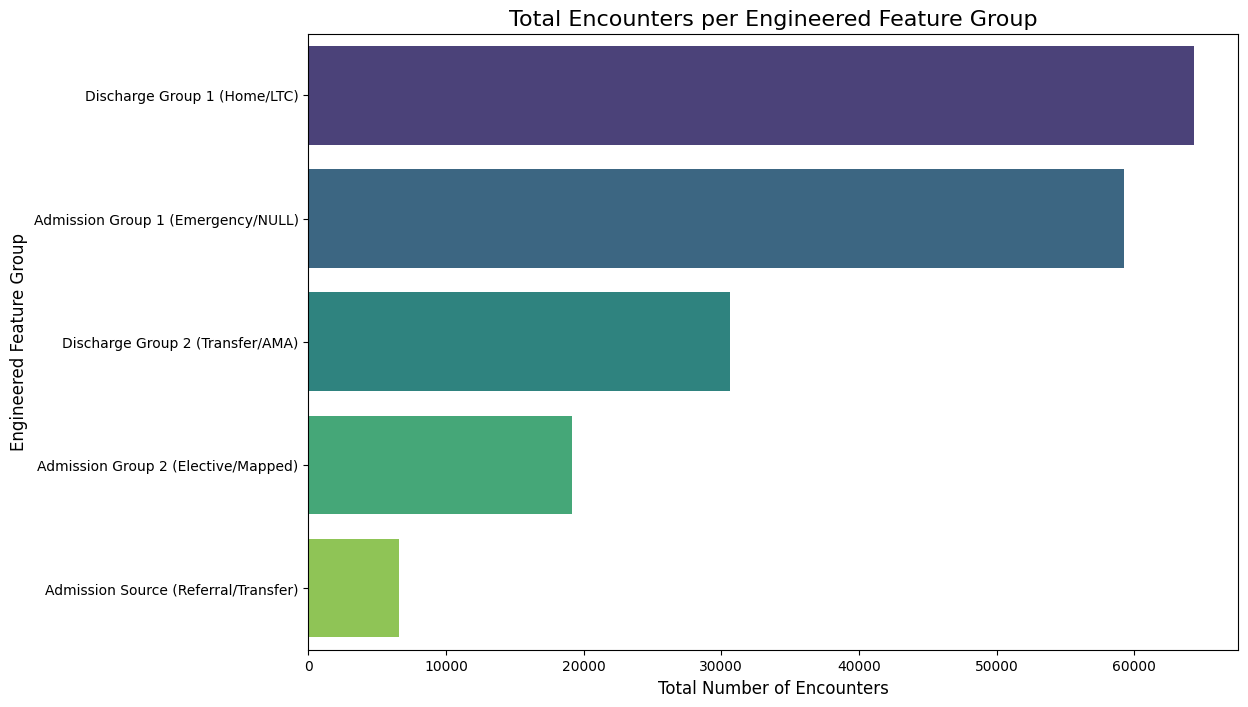

In [8]:
#install values from lookup dictionaries
medical_data['admission_type'] = medical_data['admission_type_id'].map(admission_type_id) # admission type 
medical_data['discharge_disposition'] = medical_data['discharge_disposition_id'].map(discharge_disposition_id) # discharge disposition
medical_data['admission_source'] = medical_data['admission_source_id'].map(admission_source_id) # admission source


del admission_type_id # drop the lookup dictionary
del discharge_disposition_id 
del admission_source_id

medical_data['admission_grp_1_ind'] = ( medical_data['admission_type'].isin(['NULL','Emergency'])).astype(int)
medical_data['admission_grp_2_ind'] = ( medical_data['admission_type'].isin(['Elective','Not Mapped'])).astype(int)

medical_data['discharge_grp_1_ind'] = ( medical_data['discharge_disposition'].isin(['Discharged/transferred to a long term care hospital'
                                                                           ,'NULL'
                                                                           ,'Discharged to home'])).astype(int)

medical_data['discharge_grp_2_ind'] = ( medical_data['discharge_disposition'].isin(['Left AMA'
                                                                            ,'Discharged/transferred to another type of inpatient care institution'
                                                                            ,'Discharged/transferred to SNF'
                                                                            ,'Discharged/transferred to home with home health service'
                                                                            ,'Discharged/transferred to another rehab fac including rehab units of a hospital'])).astype(int)

medical_data['admission_type_ind'] = ( medical_data['admission_source'].isin(['Clinic Referral'
                                                                     ,'Transfer from a hospital'
                                                                     ,'Transfer from another health care facility'])).astype(int)

medical_data['mb_admission_grp_1_ct'] = medical_data.groupby('patient_nbr')['admission_grp_1_ind'].transform('sum')
medical_data['mb_admission_grp_2_ct'] = medical_data.groupby('patient_nbr')['admission_grp_2_ind'].transform('sum')
medical_data['mb_discharge_grp_1_ct'] = medical_data.groupby('patient_nbr')['discharge_grp_1_ind'].transform('sum')
medical_data['mb_discharge_grp_2_ct'] = medical_data.groupby('patient_nbr')['discharge_grp_2_ind'].transform('sum')
medical_data['mb_admission_type_ct']  = medical_data.groupby('patient_nbr')['admission_type_ind'].transform('sum')

drop.extend(['payer_code', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
drop.extend(['admission_grp_1_ind','admission_grp_2_ind','discharge_grp_1_ind', 'discharge_grp_2_ind','admission_type_ind'])

# Visualize the New Feature Groups ---
# This plot helps to understand the distribution of the newly created binary features.
feature_groups_for_plot = {
    'Admission Group 1 (Emergency/NULL)': medical_data['admission_grp_1_ind'].sum(),
    'Admission Group 2 (Elective/Mapped)': medical_data['admission_grp_2_ind'].sum(),
    'Discharge Group 1 (Home/LTC)': medical_data['discharge_grp_1_ind'].sum(),
    'Discharge Group 2 (Transfer/AMA)': medical_data['discharge_grp_2_ind'].sum(),
    'Admission Source (Referral/Transfer)': medical_data['admission_type_ind'].sum()
}
plot_df = pd.DataFrame(list(feature_groups_for_plot.items()), columns=['Feature Group', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Feature Group', data=plot_df.sort_values('Count', ascending=False), palette='viridis')
plt.title('Total Encounters per Engineered Feature Group', fontsize=16)
plt.xlabel('Total Number of Encounters', fontsize=12)
plt.ylabel('Engineered Feature Group', fontsize=12)
plt.show()



In [9]:
#clean dx codes and replace missing values with ZZZ
medical_data['diag_1'] = medical_data['diag_1'].astype(str).str[ :3]
medical_data['diag_2'] = medical_data['diag_2'].astype(str).str[ :3]
medical_data['diag_3'] = medical_data['diag_3'].astype(str).str[ :3]

medical_data['diag_1'] = medical_data['diag_1'].replace('?', 'ZZZ')
medical_data['diag_2'] = medical_data['diag_2'].replace('?', 'ZZZ')
medical_data['diag_3'] = medical_data['diag_3'].replace('?', 'ZZZ')

In [10]:
#add patient-level count of unique diagnoses codes 
# Melt the dataset to have all diagnoses in a single column
diagnosis_melted = medical_data.melt(id_vars=['patient_nbr'], value_vars=['diag_1', 'diag_2', 'diag_3'])

# Group by patient_nbr and count distinct diagnosis codes
distinct_counts = diagnosis_melted.groupby('patient_nbr')['value'].nunique().reset_index()

# Rename columns for clarity
distinct_counts.columns = ['patient_nbr', 'distinct_diag_count']

medical_data = medical_data.merge(distinct_counts, on='patient_nbr', how='left')

del diagnosis_melted, distinct_counts

In [11]:
# Read the dx code lookup into dataframe 
df = pd.read_csv("data/diagnosis_num_mapping.csv")

# Convert DataFrame to a dictionary with 'diagnosis_cd' as keys and 'diagnosis' as values
diag_dict = dict(zip(df['diagnosis_cd'], df['diagnosis']))

diag_dict['ZZZ'] = 'No diag'  # Adding a new key-value pair

del df

#install descriptive diagnoses
medical_data['diagnosis_1'] = medical_data['diag_1'].map(diag_dict)
medical_data['diagnosis_2'] = medical_data['diag_2'].map(diag_dict)
medical_data['diagnosis_3'] = medical_data['diag_3'].map(diag_dict)

In [12]:
medical_data['diag_1_freq'] = medical_data.groupby('diag_1')['diag_1'].transform('count')
medical_data['diag_2_freq'] = medical_data.groupby('diag_2')['diag_2'].transform('count')
medical_data['diag_3_freq'] = medical_data.groupby('diag_3')['diag_3'].transform('count')

In [13]:
# Indicator variables for Life-Threatening Infections & Sepsis
for code in ['38', '40', '36', '320', '324']:
    medical_data[f'LTIS_{code}_ind'] = (medical_data['diag_1'] == code).astype(int)
    medical_data[f'LTIS_{code}_ind'] = (medical_data['diag_2'] == code).astype(int)
    medical_data[f'LTIS_{code}_ind'] = (medical_data['diag_3'] == code).astype(int)

# Indicator variables for Cardiovascular Emergencies
for code in ['410', '430', '431', '415', '428']:
    medical_data[f'CE_{code}_ind'] = (medical_data['diag_1'] == code).astype(int)
    medical_data[f'CE_{code}_ind'] = (medical_data['diag_2'] == code).astype(int)
    medical_data[f'CE_{code}_ind'] = (medical_data['diag_3'] == code).astype(int)

# Indicator variables for Cancer (Malignant Neoplasms)
for code in ['155', '162', '191', '197', '199']:
    medical_data[f'CMN_{code}_ind'] = (medical_data['diag_1'] == code).astype(int)
    medical_data[f'CMN_{code}_ind'] = (medical_data['diag_2'] == code).astype(int)
    medical_data[f'CMN_{code}_ind'] = (medical_data['diag_3'] == code).astype(int)

# Indicator variables for Organ Failure
for code in ['570', '584', '585', '277']:
    medical_data[f'OF_{code}_ind'] = (medical_data['diag_1'] == code).astype(int)
    medical_data[f'OF_{code}_ind'] = (medical_data['diag_2'] == code).astype(int)
    medical_data[f'OF_{code}_ind'] = (medical_data['diag_3'] == code).astype(int)

# Indicator variables for Neurological & Brain Disorders
for code in ['331', '340', '780', '852']:
    medical_data[f'NBD_{code}_ind'] = (medical_data['diag_1'] == code).astype(int)
    medical_data[f'NBD_{code}_ind'] = (medical_data['diag_2'] == code).astype(int)
    medical_data[f'NBD_{code}_ind'] = (medical_data['diag_3'] == code).astype(int)

# Indicator variables for Severe Trauma & Injuries
for code in ['806', '861', '864', '958']:
    medical_data[f'STI_{code}_ind'] = (medical_data['diag_1'] == code).astype(int)
    medical_data[f'STI_{code}_ind'] = (medical_data['diag_2'] == code).astype(int)
    medical_data[f'STI_{code}_ind'] = (medical_data['diag_3'] == code).astype(int)

# Indicator variables for Other Critical Conditions
for code in ['250', '995', '986', '989']:
    medical_data[f'OCC_{code}_ind'] = (medical_data['diag_1'] == code).astype(int)
    medical_data[f'OCC_{code}_ind'] = (medical_data['diag_2'] == code).astype(int)
    medical_data[f'OCC_{code}_ind'] = (medical_data['diag_3'] == code).astype(int)


In [14]:
# --- Pre-computation Setup ---------------------------------------------------
# This script assumes you have a pandas DataFrame named 'medical_data'.
# It also assumes you have a dictionary named 'diag_dict' that maps
# diagnosis codes (like '428') to their descriptions (like 'Congestive Heart Failure').
#
# Example:
# medical_data = pd.read_csv('your_data.csv')
# diag_dict = {'428': 'Congestive Heart Failure', '250': 'Diabetes Mellitus', ...}
# -----------------------------------------------------------------------------


# --- Step 1: Combine and Sort Diagnosis Codes --------------------------------
# The goal here is to treat the three diagnosis columns as a single entity.
# We sort them so that the order doesn't matter when we count combinations.
# For example, a patient with diagnoses (428, 250, 401) will be treated the same
# as a patient with (250, 401, 428).

print("Step 1: Combining and sorting diagnoses for each patient...")

# Create a new column 'sorted_diagnoses_list' that contains a sorted list
# of the three diagnosis codes for each patient.
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']
medical_data['sorted_diagnoses_list'] = medical_data[diagnosis_columns].values.tolist()
medical_data['sorted_diagnoses_list'] = medical_data['sorted_diagnoses_list'].apply(sorted)

print(" -> Done. Created 'sorted_diagnoses_list' column.\n")


# --- Step 2: Calculate the Frequency of Each Diagnosis Combination ----------
# Now, we count how many times each unique *combination* of three diagnoses appears
# in the entire dataset.

print("Step 2: Calculating frequency of diagnosis combinations...")

# To use groupby, we need a hashable type, so we convert the list to a tuple.
medical_data['sorted_diagnoses_tuple'] = medical_data['sorted_diagnoses_list'].apply(tuple)

# Use groupby().transform('count') to count occurrences of each tuple and
# assign that count to every row with that same tuple.
medical_data['diagnosis_combo_frequency'] = medical_data.groupby('sorted_diagnoses_tuple')['sorted_diagnoses_tuple'].transform('count')

# We no longer need the temporary tuple column, so we can drop it.
medical_data.drop(columns=['sorted_diagnoses_tuple'], inplace=True)

print(" -> Done. Created 'diagnosis_combo_frequency' column.\n")


# --- Step 3: Analyze Frequencies of Individual Sorted Diagnoses -------------
# This step creates three new columns containing the sorted diagnoses. This makes it
# easy to see the most common primary, secondary, and tertiary diagnoses
# *after* they have been put in a consistent order.

print("Step 3: Analyzing frequencies of individual diagnoses in their sorted positions...")

# Split the sorted list back into three separate columns.
medical_data[['sorted_diag_1', 'sorted_diag_2', 'sorted_diag_3']] = pd.DataFrame(
    medical_data['sorted_diagnoses_list'].tolist(),
    index=medical_data.index
)

# Calculate the frequency of each diagnosis code in each of the three sorted positions.
medical_data['sorted_diag_1_frequency'] = medical_data.groupby('sorted_diag_1')['sorted_diag_1'].transform('count')
medical_data['sorted_diag_2_frequency'] = medical_data.groupby('sorted_diag_2')['sorted_diag_2'].transform('count')
medical_data['sorted_diag_3_frequency'] = medical_data.groupby('sorted_diag_3')['sorted_diag_3'].transform('count')

print(" -> Done. Created sorted diagnosis columns and their frequency columns.\n")


# --- Step 4: Final Formatting and Cleanup ------------------------------------
# The final steps are to create a clean string representation of the diagnosis
# combination and to map the diagnosis codes to their human-readable descriptions.

print("Step 4: Formatting and cleaning up...")

# Create a user-friendly string representation of the sorted diagnosis combination.
# e.g., ['250', '401', '428'] becomes '(250 401 428)'
medical_data['diagnosis_combo_string'] = medical_data['sorted_diagnoses_list'].apply(lambda x: f"({' '.join(map(str, x))})")

# Now that we're done with all calculations, drop the list column.
medical_data.drop(columns=['sorted_diagnoses_list'], inplace=True)

# Use the pre-defined 'diag_dict' to replace codes with full text descriptions.
# This makes the final DataFrame much easier to read.
# We apply this to the sorted columns for clarity.
# Note: Ensure 'diag_dict' is defined before this step!
if 'diag_dict' in locals() or 'diag_dict' in globals():
    medical_data['sorted_diag_1'] = medical_data['sorted_diag_1'].map(diag_dict)
    medical_data['sorted_diag_2'] = medical_data['sorted_diag_2'].map(diag_dict)
    medical_data['sorted_diag_3'] = medical_data['sorted_diag_3'].map(diag_dict)
    del diag_dict # Clean up the dictionary from memory
else:
    print("Warning: 'diag_dict' not found. Skipping diagnosis description mapping.")

print(" -> Done. Final formatting complete.\n")


# --- Step 5: Create Indicator for High-Risk Diagnosis Combinations ---------
# This step creates a binary flag for patients with diagnosis combinations
# that are known to be clinically significant and may lead to higher readmission rates.

print("Step 5: Creating a high-risk patient indicator...")

# Define a custom list of high-risk diagnosis combinations.
# These combinations often represent severe comorbidity scenarios for diabetic patients.
# Note: Codes within each tuple are pre-sorted to match 'diagnosis_combo_string'.
high_risk_combinations = [
    ' (250 401 428)', # Diabetes, Hypertension, Congestive Heart Failure
    ' (250 410 428)', # Diabetes, Heart Attack, Congestive Heart Failure
    ' (250 403 585)', # Diabetes, Hypertensive Chronic Kidney Disease, Chronic Kidney Disease
    ' (250 428 585)', # Diabetes, Congestive Heart Failure, Chronic Kidney Disease
    ' (250 486 496)', # Diabetes, Pneumonia, Chronic Airway Obstruction
    ' (250 682 707)', # Diabetes, Cellulitis, Decubitus Ulcer
    ' (414 427 428)', # Coronary Atherosclerosis, Cardiac Dysrhythmias, Heart Failure
]

# Create the indicator column. It will be 1 if the patient's diagnosis combo
# is in our high-risk list, and 0 otherwise.
medical_data['is_high_risk_combo'] = medical_data['diagnosis_combo_string'].isin(high_risk_combinations).astype(int)

print(" -> Done. Created 'is_high_risk_combo' indicator column.\n")
print("Data processing finished. Check the 'medical_data' DataFrame for new columns.")


Step 1: Combining and sorting diagnoses for each patient...
 -> Done. Created 'sorted_diagnoses_list' column.

Step 2: Calculating frequency of diagnosis combinations...
 -> Done. Created 'diagnosis_combo_frequency' column.

Step 3: Analyzing frequencies of individual diagnoses in their sorted positions...
 -> Done. Created sorted diagnosis columns and their frequency columns.

Step 4: Formatting and cleaning up...
 -> Done. Final formatting complete.

Step 5: Creating a high-risk patient indicator...
 -> Done. Created 'is_high_risk_combo' indicator column.

Data processing finished. Check the 'medical_data' DataFrame for new columns.


In [15]:
dx_list=[ '428'
, '403'
, '707'
, '585'
, '491'
, '396'
, '440'
, '453'
, '571'
, '284'
, '304'
, '482'
, '150'
, '282'
, '332'
, '443'
, '719'
, '423'
, '281'
, '536'
, '368'
, '515'
, '595'
, '572'
, '681'
, '581'
, '537'
, '490'
, '583'
, 'V46'
, '519'
, '300'
, '567'
, 'E92'
, 'V49'
, '094'
, '514'
, '494'
, '042'
, '404'
, '346'
, '792'
, '398'
, '753'
, '577'
, '730'
, '444'
, '459'
, '790'
, '337'
, '397'
, '292'
, 'V42'
, '289']


In [16]:
# Create dx_events with the selected columns
dx_events = medical_data[['patient_nbr', 'encounter_id', 'diag_1', 'diag_2', 'diag_3']].copy(deep=True)

# Add new empty columns for each element in dx_list
for dx in dx_list:
    dx_events[f'dx_{dx}_ind'] = pd.NA  # Creates empty columns with missing values (best for Pandas)

print(dx_events.shape)

(101766, 59)


In [17]:

# populate each column
for dx in dx_list:
    dx_events[f'dx_{dx}_ind'] = ((dx_events['diag_1'] == dx) |
                                 (dx_events['diag_2'] == dx) |
                                 (dx_events['diag_3'] == dx) ).astype(int)
print('done')   

done


In [18]:

# Group by patient_nbr and compute max and sum for each diagnosis indicator
dx_aggregated = dx_events.groupby('patient_nbr').agg(
    {f'dx_{dx}_ind': ['max', 'sum'] for dx in dx_list}
)

# Rename columns to match SQL-style naming
dx_aggregated.columns = [f'{col[0]}_{col[1]}' for col in dx_aggregated.columns]

# Reset index to bring patient_nbr back as a column
dx_aggregated = dx_aggregated.reset_index()

del dx_events

In [19]:

print(medical_data.shape)
medical_data = medical_data.merge(dx_aggregated, on='patient_nbr', how='left')
print(medical_data.shape)
del dx_aggregated

(101766, 111)
(101766, 219)


In [20]:

medical_data['alcohol_ind'] = medical_data[['diagnosis_1', 'diagnosis_2', 'diagnosis_3']].apply(
    lambda row: int(any('ALCOHOL' in str(val) for val in row)), axis=1
)

medical_data['obesity_ind'] = medical_data[['diagnosis_1', 'diagnosis_2', 'diagnosis_3']].apply(
    lambda row: int(any('OBESITY' in str(val) for val in row)), axis=1
)

medical_data['mh_ind'] = medical_data[['diagnosis_1', 'diagnosis_2', 'diagnosis_3']].apply(
    lambda row: int(any('MALIGNANT HYPERTENSION' in str(val) for val in row)), axis=1
)

In [21]:

medical_data['alcohol_history_ind'] = medical_data.groupby('patient_nbr')['alcohol_ind'].transform('max')
medical_data['obesity_history_ind'] = medical_data.groupby('patient_nbr')['obesity_ind'].transform('max')
medical_data['mh_history_ind'] = medical_data.groupby('patient_nbr')['mh_ind'].transform('max')

drop.extend(['alcohol_ind', 'obesity_ind', 'mh_ind'])

In [22]:

medical_data['readmitted_lt30_ind'] = ( medical_data['readmitted']=='<30' ).astype(int)
medical_data['readmitted_gt30_ind'] = ( medical_data['readmitted']=='>30' ).astype(int)
medical_data['readmitted_no_ind'] = ( medical_data['readmitted']=='NO' ).astype(int)
medical_data['readmitted_ind'] = medical_data['readmitted_lt30_ind'] + medical_data['readmitted_gt30_ind']

In [23]:

#add patient-level some features
medical_data['encounter_ct'] = medical_data['patient_nbr'].map(medical_data.groupby('patient_nbr')['encounter_id'].nunique())
medical_data['mb_time_in_hospital'] = medical_data.groupby('patient_nbr')['time_in_hospital'].transform('sum')
medical_data['mb_readmitted_lt30_ct'] = medical_data.groupby('patient_nbr')['readmitted_lt30_ind'].transform('sum')
medical_data['mb_readmitted_gt30_ct'] = medical_data.groupby('patient_nbr')['readmitted_gt30_ind'].transform('sum')
medical_data['mb_readmitted_no_ct'] = medical_data.groupby('patient_nbr')['readmitted_no_ind'].transform('sum')
medical_data['mb_num_lab_procedures_ct'] = medical_data.groupby('patient_nbr')['num_lab_procedures'].transform('sum')
medical_data['mb_num_procedures_ct'] = medical_data.groupby('patient_nbr')['num_procedures'].transform('sum')
medical_data['mb_num_medications_ct'] = medical_data.groupby('patient_nbr')['num_medications'].transform('sum')
medical_data['mb_number_outpatient_ct'] = medical_data.groupby('patient_nbr')['number_outpatient'].transform('sum')
medical_data['mb_number_emergency_ct'] = medical_data.groupby('patient_nbr')['number_emergency'].transform('sum')
medical_data['mb_number_inpatient_ct'] = medical_data.groupby('patient_nbr')['number_inpatient'].transform('sum')
medical_data['mb_number_diagnoses_ct'] = medical_data.groupby('patient_nbr')['number_diagnoses'].transform('sum')

drop.extend(['readmitted_lt30_ind', 'readmitted_gt30_ind', 'readmitted_no_ind'])

In [24]:

# delete patients whose history includes childhood or old age

medical_data['under20_ind'] = medical_data['age'].isin(['[0-10)','[10-20)']).astype(int)
medical_data['over80_ind']  = medical_data['age'].isin(['[80-90)', '[90-100)']).astype(int)

medical_data['mb_under20_ind'] = medical_data.groupby('patient_nbr')['under20_ind'].transform('max')
medical_data['mb_over80_ind'] = medical_data.groupby('patient_nbr')['over80_ind'].transform('max')

age_to_numeric_map = {
    '[20-30)': 1,
    '[30-40)': 2,
    '[40-50)': 3,
    '[50-60)': 4,
    '[60-70)': 5,
    '[70-80)': 6
}

medical_data['age_encoded'] = medical_data['age'].map(age_to_numeric_map)

drop.extend(['age','under20_ind', 'over80_ind'])

In [25]:
drop.extend([ 'citoglipton'
, 'examide'
, 'acetohexamide'
, 'glimepiride-pioglitazone'
, 'metformin-pioglitazone'
, 'metformin-rosiglitazone'
, 'troglitazone'
, 'glipizide-metformin'
, 'tolbutamide'
, 'miglitol'
, 'tolazamide'
, 'chlorpropamide'
, 'acarbose'
, 'nateglinide'
, 'glyburide-metformin'
, 'repaglinide'
 ])

In [26]:

print(medical_data.groupby('encounter_ct')['patient_nbr'].nunique().reset_index().sort_values('encounter_ct'))

    encounter_ct  patient_nbr
0              1        54745
1              2        10434
2              3         3328
3              4         1421
4              5          717
5              6          346
6              7          207
7              8          111
8              9           70
9             10           42
10            11           20
11            12           19
12            13           14
13            14            5
14            15            9
15            16            4
16            17            3
17            18            6
18            19            3
19            20            6
20            21            1
21            22            2
22            23            3
23            28            1
24            40            1


In [27]:

print(medical_data.shape)
#remove very young and very old members, members who died, unknown gender
medical_data = medical_data[
    (medical_data['expiration_ind'] != 1 ) &
    (medical_data['mb_under20_ind'] != 1 ) &
    (medical_data['mb_over80_ind']  != 1 ) &
    (medical_data['gender'] != 'Unknown/Invalid') &  # Exclude records with gender 'Unknown/Invalid'
    (medical_data['encounter_ct'] < 14 )  # Exclude records with gender 'Unknown/Invalid'
]
print(medical_data.shape)

drop.extend(['mb_under20_ind', 'mb_over80_ind', 'expiration_ind'])

(101766, 246)
(78049, 246)


In [28]:

medical_data.drop(columns=drop, inplace=True)
medical_data['dummy']=1
medical_data.to_csv('medical_data.csv',index=False)
print(medical_data.shape)
print(medical_data.info())

(78049, 206)
<class 'pandas.core.frame.DataFrame'>
Index: 78049 entries, 2 to 101765
Columns: 206 entries, encounter_id to dummy
dtypes: float64(1), int64(180), object(25)
memory usage: 123.3+ MB
None


In [29]:
# Define the list of columns to drop after feature engineering is complete.
# These are the original diagnosis columns and the intermediate columns used
# for calculation and analysis.

drop.extend([
    # --- Original Diagnosis Columns (now redundant) ---
    'diag_1',
    'diag_2',
    'diag_3',

    # --- Sorted Diagnosis Description Columns (now replaced by features) ---
    'sorted_diag_1',
    'sorted_diag_2',
    'sorted_diag_3',

    # --- Intermediate Frequency Calculation Columns ---
    'diagnosis_combo_frequency',
    'sorted_diag_1_frequency',
    'sorted_diag_2_frequency',
    'sorted_diag_3_frequency',

    # --- Intermediate Combination String (optional to keep for inspection) ---
    # This column was used to create the 'is_high_risk_combo' feature.
    # You can comment it out if you want to keep it for debugging or analysis.
    'diagnosis_combo_string',
        
    'A1cresult',
    'metformin',
    'glimepiride',
    'glipizide',    
    'glyburide',
    'pioglitazone',
    'rosiglitazone',
    'insulin',
])


# Example of how to use the list to drop the columns from your DataFrame
# medical_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# print("Dropped intermediate and redundant columns.")

In [30]:
medical_data.drop(columns=drop, inplace=True, errors='ignore')
medical_data.to_pickle("medical_data.pkl")
print(medical_data.shape)
print(medical_data.info())

(78049, 188)
<class 'pandas.core.frame.DataFrame'>
Index: 78049 entries, 2 to 101765
Data columns (total 188 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    encounter_id              78049 non-null  int64  
 1    patient_nbr               78049 non-null  int64  
 2    gender                    78049 non-null  object 
 3    time_in_hospital          78049 non-null  int64  
 4    num_lab_procedures        78049 non-null  int64  
 5    num_procedures            78049 non-null  int64  
 6    num_medications           78049 non-null  int64  
 7    number_outpatient         78049 non-null  int64  
 8    number_emergency          78049 non-null  int64  
 9    number_inpatient          78049 non-null  int64  
 10   number_diagnoses          78049 non-null  int64  
 11   A1Cresult                 13734 non-null  object 
 12   change                    78049 non-null  object 
 13   diabetesMed               78049 non

In [31]:
for _ in medical_data.columns:
    print("column names :", _)

column names : encounter_id
column names : patient_nbr
column names : gender
column names : time_in_hospital
column names : num_lab_procedures
column names : num_procedures
column names : num_medications
column names : number_outpatient
column names : number_emergency
column names : number_inpatient
column names : number_diagnoses
column names : A1Cresult
column names : change
column names : diabetesMed
column names : readmitted
column names : admission_type
column names : discharge_disposition
column names : admission_source
column names : mb_admission_grp_1_ct
column names : mb_admission_grp_2_ct
column names : mb_discharge_grp_1_ct
column names : mb_discharge_grp_2_ct
column names : mb_admission_type_ct
column names : distinct_diag_count
column names : diagnosis_1
column names : diagnosis_2
column names : diagnosis_3
column names : diag_1_freq
column names : diag_2_freq
column names : diag_3_freq
column names : LTIS_38_ind
column names : LTIS_40_ind
column names : LTIS_36_ind
column

In [32]:
import pandas as pd

# Set display options to show all columns and rows without limits
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Now, when you print the head of your DataFrame (or the whole thing),
# all columns will be visible.
medical_data.head()

,encounter_id,patient_nbr,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult,change,diabetesMed,readmitted,admission_type,discharge_disposition,admission_source,mb_admission_grp_1_ct,mb_admission_grp_2_ct,mb_discharge_grp_1_ct,mb_discharge_grp_2_ct,mb_admission_type_ct,distinct_diag_count,diagnosis_1,diagnosis_2,diagnosis_3,diag_1_freq,diag_2_freq,diag_3_freq,LTIS_38_ind,LTIS_40_ind,LTIS_36_ind,LTIS_320_ind,LTIS_324_ind,CE_410_ind,CE_430_ind,CE_431_ind,CE_415_ind,CE_428_ind,CMN_155_ind,CMN_162_ind,CMN_191_ind,CMN_197_ind,CMN_199_ind,OF_570_ind,OF_584_ind,OF_585_ind,OF_277_ind,NBD_331_ind,NBD_340_ind,NBD_780_ind,NBD_852_ind,STI_806_ind,STI_861_ind,STI_864_ind,STI_958_ind,OCC_250_ind,OCC_995_ind,OCC_986_ind,OCC_989_ind,is_high_risk_combo,dx_428_ind_max,dx_428_ind_sum,dx_403_ind_max,dx_403_ind_sum,dx_707_ind_max,dx_707_ind_sum,dx_585_ind_max,dx_585_ind_sum,dx_491_ind_max,dx_491_ind_sum,dx_396_ind_max,dx_396_ind_sum,dx_440_ind_max,dx_440_ind_sum,dx_453_ind_max,dx_453_ind_sum,dx_571_ind_max,dx_571_ind_sum,dx_284_ind_max,dx_284_ind_sum,dx_304_ind_max,dx_304_ind_sum,dx_482_ind_max,dx_482_ind_sum,dx_150_ind_max,dx_150_ind_sum,dx_282_ind_max,dx_282_ind_sum,dx_332_ind_max,dx_332_ind_sum,dx_443_ind_max,dx_443_ind_sum,dx_719_ind_max,dx_719_ind_sum,dx_423_ind_max,dx_423_ind_sum,dx_281_ind_max,dx_281_ind_sum,dx_536_ind_max,dx_536_ind_sum,dx_368_ind_max,dx_368_ind_sum,dx_515_ind_max,dx_515_ind_sum,dx_595_ind_max,dx_595_ind_sum,dx_572_ind_max,dx_572_ind_sum,dx_681_ind_max,dx_681_ind_sum,dx_581_ind_max,dx_581_ind_sum,dx_537_ind_max,dx_537_ind_sum,dx_490_ind_max,dx_490_ind_sum,dx_583_ind_max,dx_583_ind_sum,dx_V46_ind_max,dx_V46_ind_sum,dx_519_ind_max,dx_519_ind_sum,dx_300_ind_max,dx_300_ind_sum,dx_567_ind_max,dx_567_ind_sum,dx_E92_ind_max,dx_E92_ind_sum,dx_V49_ind_max,dx_V49_ind_sum,dx_094_ind_max,dx_094_ind_sum,dx_514_ind_max,dx_514_ind_sum,dx_494_ind_max,dx_494_ind_sum,dx_042_ind_max,dx_042_ind_sum,dx_404_ind_max,dx_404_ind_sum,dx_346_ind_max,dx_346_ind_sum,dx_792_ind_max,dx_792_ind_sum,dx_398_ind_max,dx_398_ind_sum,dx_753_ind_max,dx_753_ind_sum,dx_577_ind_max,dx_577_ind_sum,dx_730_ind_max,dx_730_ind_sum,dx_444_ind_max,dx_444_ind_sum,dx_459_ind_max,dx_459_ind_sum,dx_790_ind_max,dx_790_ind_sum,dx_337_ind_max,dx_337_ind_sum,dx_397_ind_max,dx_397_ind_sum,dx_292_ind_max,dx_292_ind_sum,dx_V42_ind_max,dx_V42_ind_sum,dx_289_ind_max,dx_289_ind_sum,alcohol_history_ind,obesity_history_ind,mh_history_ind,readmitted_ind,encounter_ct,mb_time_in_hospital,mb_readmitted_lt30_ct,mb_readmitted_gt30_ct,mb_readmitted_no_ct,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,age_encoded,dummy
2,64410,86047875,Female,2,11,5,13,2,0,1,6,NaN,No,Yes,NO,Emergency,Discharged to home,Emergency Room,1,0,1,0,0,3,DIABETES IN PREG-UNSPEC,DIABETES MELLITUS,DELIVER-SINGLE LIVEBORN,285,12794,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,11,5,13,2,0,1,6,1.0,1
3,500364,82442376,Male,2,44,1,16,0,0,0,7,NaN,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,1,0,1,0,0,3,INTEST INFEC E COLI NOS,DIABETES MELLITUS,MAL HY KID W CR KID I-IV,515,12794,2357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,44,1,16,0,0,0,7,2.0,1
4,16680,42519267,Male,1,51,0,8,0,0,0,5,NaN,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,1,0,1,0,0,3,SECONDARY MALIG NEO LUNG,MAL NEO PANCREAS HEAD,DIABET